In [1]:
# Fill in your name using the format below and student ID number
your_name = "Van Gendt, Fabien"
student_id = "0918181"

In [2]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [3]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [4]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.__version__

'2.1.0'

In [6]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [7]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Fabien, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [8]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = './'

In [9]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [10]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [11]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [12]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [13]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

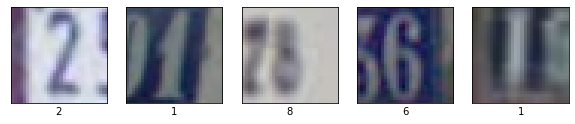

In [14]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [15]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

Loading model from file
Success!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                30730     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.233230  0.190388  2.233088      0.190974
max  2.245386  0.190954  2.233112      0.190974


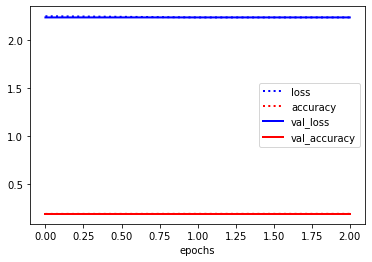

In [16]:
# Toy usage example
# Remove before submission
from tensorflow.keras import models
from tensorflow.keras import layers 

def build_toy_model():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# First build and store
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=False, epochs=3, batch_size=32)

Loading model from file
Success!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                30730     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.233230  0.190388  2.233088      0.190974
max  2.245386  0.190954  2.233112      0.190974


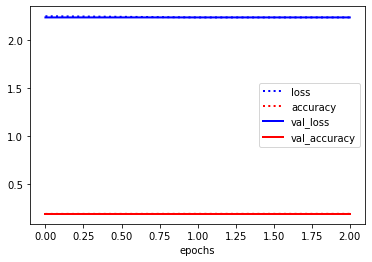

In [17]:
# Toy usage example
# Remove before submission
# With train=False: load from file and report the same results without rerunning
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=False)

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Loading model from file
Success!
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_86 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_420 (Dense)            (None, 300)               921900    
_________________________________________________________________
dense_421 (Dense)            (None, 200)               60200     
_________________________________________________________________
dense_422 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_423 (Dense)            (None, 10)                1010      
Total params: 1,003,210
Trainable params: 1,003,210
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.505630  0.342267

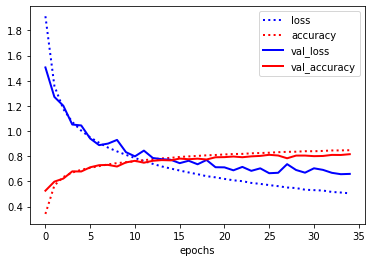

In [18]:
from tensorflow.keras import models, layers, optimizers

def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(32,32,3)))
    model.add(layers.Dense(300, activation='relu'))
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))

    model.add(layers.Dense(10, activation='softmax'))
    
    opt = optimizers.RMSprop(learning_rate=0.0001)
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    
run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=False, epochs=35,batch_size=32)

answer_q_1_1 = """
This network finds a model that is complex enough to achieve the desired performance. Larger networks
were not worth it. Since the validation loss was noisy, the learning rate was reduced for better convergence and resulted in a lower minimum due to less overshooting.
To compensate for this and stay within the limit of epochs a small batchsize is chosen.
Another optimzer like adagrad was only learning more slowly. Early stopping was used as the model slowly started to overfit after 35 epochs.
"""
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [19]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

Loading model from file
Success!
Model: "sequential_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_135 (Flatten)        (None, 1024)              0         
_________________________________________________________________
dense_604 (Dense)            (None, 300)               307500    
_________________________________________________________________
dense_605 (Dense)            (None, 200)               60200     
_________________________________________________________________
dense_606 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_607 (Dense)            (None, 10)                1010      
Total params: 388,810
Trainable params: 388,810
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.441228  0.324956  0

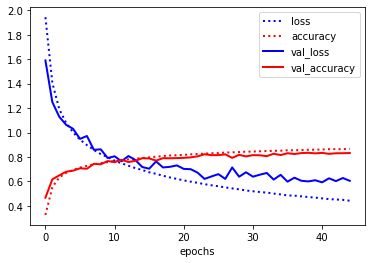

In [20]:
prep_X_train = rgb2gray(X_train)
prep_X_val = rgb2gray(X_val)

# Replace with the preprocessed data
preprocessed_split = prep_X_train, prep_X_val, y_train, y_val

# Adjusted model
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(32,32,1)))
    model.add(layers.Dense(300, activation='relu'))
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    opt = optimizers.RMSprop(learning_rate=0.0001)
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=False, epochs=45, batch_size=32)
answer_q_1_2 = """
The same configuration was used to train the model on the greyscaled images, except the number of epochs was changed to 100
to see how the learning curves develop. The model now starts overfitting after around 50 epochs
at the same pace as the previous model and performs better (83% acc). The improvement is due to the fact that the model doesn't
need to try to learn from colors, which are irrelevant features for this classification problem.
"""
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Loading model from file
Success!
Model: "sequential_142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_140 (Flatten)        (None, 1024)              0         
_________________________________________________________________
dense_624 (Dense)            (None, 300)               307500    
_________________________________________________________________
dropout_26 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_625 (Dense)            (None, 200)               60200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_626 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout

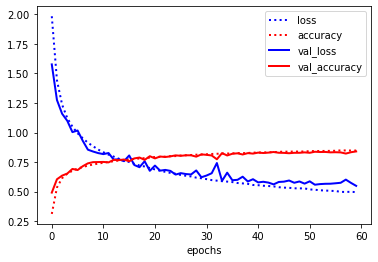

In [21]:
from tensorflow.keras import regularizers

def build_model_1_3():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(32,32,1)))
    model.add(layers.Dense(300, activation='relu'))#, kernel_regularizer=regularizers.l1(0.00001)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(200, activation='relu'))#, kernel_regularizer=regularizers.l1(0.00001)))
    model.add(layers.Dropout(0.05))
    model.add(layers.Dense(100, activation='relu'))#, kernel_regularizer=regularizers.l1(0.00001)))
    model.add(layers.Dropout(0.01))
#     model.add(layers.Dense(300, activation='relu'))
#     model.add(layers.Dense(200, activation='relu'))
#     model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    opt = optimizers.RMSprop(learning_rate=0.0001)
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=False, epochs=60, batch_size=32)
answer_q_1_3 = """
L1 and L2 regularization reduced the overfitting a lot, but did not find a better model.
Using a dropout rate of 50% resulted in the model to underfit: the training loss did not decrease anymore after 40 epochs and the
validation accuracy got worse. By using low dropout rates and gradually decreasing them each layer there's almost no overfitting
anymore and it also finds a slightly better model after 70 epochs (84%). 
"""
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Loading model from file
Success!
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_305 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_306 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_196 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_141 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_307 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_308 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_197 (M

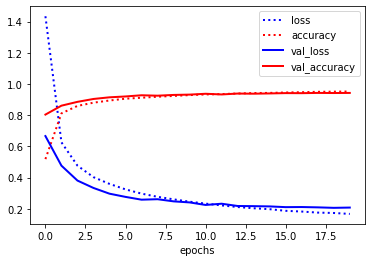

In [22]:
def build_model_2_1():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,1), padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    opt = optimizers.RMSprop(0.0003)
              
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
  
run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=False, epochs=20, batch_size=64)
answer_q_2_1 = """
I repeatedly increased the size of the model untill further expanding it did not significantly increase
the performance anymore. Larger filters did not find a better model. To reduce overfitting
and increase the translation invariance some maxpooling layers are added. Subsequent convolutional layers have
more filters, so no information gets lost. The model was still overfitting, so I experimented with various
regularization methods. Adding dropout layers with increasing dropout rates reduced the overfitting the most and yielded the
best performance. Tuning the learningrate and batchsize did slightly improve the model. It performs quite well (94.2%) and does
a much better job in classifying images than the dense network. 
"""
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

Loading model from file
Success!
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_58 (Ma

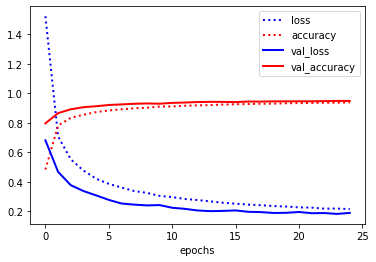

In [23]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data

from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_gen = ImageDataGenerator(
      rotation_range=0.1,
      width_shift_range=0.05,
      height_shift_range=0.05,
      zoom_range=0.15,
      fill_mode='nearest')

generator = img_gen.flow(prep_X_train, y_train, batch_size=64)
augmented_split = generator, prep_X_val, y_val

run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=False, epochs=25, batch_size=None, generator=True, steps_per_epoch=None)
answer_q_2_2 = """
Small rotations, width shifts and zooms slightly improved the model. Since all the images have slightly 
different camera angles/positions and all numbers have different fonts, the model was able to generalize sligthly better. The
augmentations shouldn't be overly done, because then they hurt the model. Shearing and flipping
slightly worsened the model. After evaluating the augmentations independetly, I combined the beneficial ones which added another slight
improvement to the model (94.8%).
"""
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

In [24]:
from sklearn.metrics import confusion_matrix

model_3_1 = load_model_from_file(base_dir, "model_2_2")
prep_X_test = rgb2gray(X_test)
y_pred = model_3_1.predict(prep_X_test)
#Uncomment to evaluate on testset
#model_3_1.evaluate(prep_X_test, y_test)

test_accuracy_3_1 = 0.9498
def plot_confusion_matrix():
    labels = [1,2,3,4,5,6,7,8,9,0]
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    plt.imshow(cm)
    plt.xticks(np.arange(10), labels=labels)
    plt.yticks(np.arange(10), labels=labels)
    plt.ylabel("true")
    plt.xlabel("pred")
    for i in range(100):
        plt.text(int(i/10), i%10, cm[i%10,int(i/10)], ha="center", va="center", color="w")

def plot_misclassifications():
    six_true = np.where(np.argmax(y_test, axis=1) == 5)[0]
    six_pred = np.where(np.argmax(y_pred, axis=1) == 5)[0]
    missed = np.setdiff1d(six_true, six_pred)
    rand_idx = np.random.choice(missed, 8, replace=False)  
    plot_images(X_test[rand_idx], y_pred[rand_idx], grayscale=True)

answer_q_3_1 = """
By looking at the confusion matrix we observe that for example the numbers 3,4 and 7 are often misclassified as a 1 and
the numbers 3 and 6 are often misclassified as an 8. The numbers 1 and 7 are confused the most. Then I randomly
plotted some misclassified sixes with their predictions to understand the misclassifications. We observe that either the image is blurry, not 
cropped properly around the six, severely rotated or the six is hardly distinguisable from the background.
"""
print("Answer is {} characters long".format(len(answer_q_3_1)))

# plot_confusion_matrix()
# plot_misclassifications()

Answer is 483 characters long


# Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

In [25]:
def plot_activations():
    img = np.expand_dims(prep_X_test[0], axis=0)
    model = load_model_from_file(base_dir, "model_2_2")
    layer_outputs = [layer.output for layer in model.layers]
    act_model = models.Model(inputs=model.inputs, outputs=layer_outputs)
    act_layers = act_model.predict(img)
    conv_layers = [0,4,5]
    
    for i, conv_layer in enumerate(conv_layers):
        feature_map = act_layers[conv_layer]
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        n_columns = 16
        n_rows = n_features // n_columns
        grid = np.zeros((n_rows*size, n_columns*size))
        for row in range(n_rows):
            for col in range(n_columns):
                channel_image = feature_map[0, :, :, col+(row*16)]
                #Post-processing for a better visualization (lab session)
                channel_image -= channel_image.mean()
                if (channel_image.std() != 0):
                    channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                grid[row*size:(row+1)*size, col*size:(col+1)*size] = channel_image

        scale = 1. / size
        plt.figure(figsize=((scale*grid.shape[1]), scale*grid.shape[0]))
        plt.title("Activation of layer {}".format(conv_layer))
        plt.axis('off')
        plt.imshow(grid, aspect='auto', cmap='viridis')
# plot_activations()
answer_q_3_2 = """
In the first layer we see that most filters are edge detectors, e.g. filter 16 reacts strongly
to vertical edges, filter 22 more to diagonal edges and filter 27 on all edges.
Some filters (eg. 2) do not react at all and some (eg. 24) mostly leave the image unchanged.
In deeper layers the resolution reduces and it's getting harder to see where is paid attention to. The model mostly
looks to different regions and patterns in the image and is learning different levels of abstraction each layer.
"""
print("Answer is {} characters long".format(len(answer_q_3_2)))

Answer is 498 characters long


### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

In [26]:
from tensorflow.keras import backend as K
import cv2

def plot_activation_map(image, label_idx):
    #Eager execution needed to be turned off in order to retrieve the gradients.
    tf.compat.v1.disable_eager_execution()
    
    img = image
    batch_img = np.expand_dims(img, axis=0)
    model = load_model_from_file(base_dir, "model_2_2")
    last_conv_layer = model.get_layer("conv2d_99")
    
    gradients = K.gradients(model.output[:,label_idx], last_conv_layer.output)[0]
    pooled_gradients = K.mean(gradients, axis=(0,1,2))
    iterate = K.function([model.input], [pooled_gradients, last_conv_layer.output[0]])
    pooled_gradients_value, conv_layer_output_value = iterate([batch_img])
    for i in range(128):
        conv_layer_output_value[:, :, i] *= pooled_gradients_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_inversed = cv2.cvtColor(heatmap.astype('float32'), cv2.COLOR_BGR2RGB)
    superimposed_img = (0.3*heatmap_inversed)+(255 * img)
    plt.title("Class activation map, label index {}".format(label_idx))
    plt.axis('off')
    plt.imshow(superimposed_img.astype('uint8'))

def plot_3_3():
    plot_activation_map(prep_X_test[0], 7)
# plot_3_3()

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

In [27]:
m = load_model_from_file(base_dir,"model_4_1")
m.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)       

Loading model from file
Success!
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D

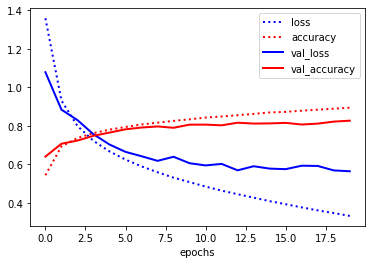

In [28]:
from tensorflow.keras.applications.vgg16 import VGG16

def build_model_4_1():
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))
    model = models.Sequential()
    trainable = False
    for layer in conv_base.layers:
        if layer.name == "block5_conv1":
             trainable = True
        layer.trainable = trainable
        model.add(layer)

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    opt = optimizers.RMSprop(0.00001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    
run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=False, epochs=20, batch_size=64)

answer_q_4_1 = """
Freezing the entire convolutional base and only training the dense part of the model only gives about 54% accuracy on the
validation set. Fine-uning, i.e. unfreezing the last 3 convolutional layers, greatly improves the performance (80%). Unfreezing more
layers (the optimum was about 6) did improve the performance, however this resulted in a model which is larger than 100MB.
Tuning the learning rate and batchsize adds another improvement (82%).
"""
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [32]:
import pickle
import gzip
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer

def store_embedding(X, name):  
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
    pickle.dump(X, file_pi)

def load_embedding(name):
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
    return pickle.load(file_pi)

def store_embeddings():
    model = load_model_from_file(base_dir, "model_4_1")
    #remove dense layers
    model.pop()
    model.pop()
    #get embeddings of last layer for X_train and X_test and store them to files
    embedding_X_train = model.predict(X_train)
    embedding_X_val = model.predict(X_val)
    embedding_X_test = model.predict(X_test)
    store_embedding(embedding_X_train, "X_train")
    store_embedding(embedding_X_val, "X_val")
    store_embedding(embedding_X_test, "X_test")
    
# store_embeddings()
    
def generate_pipeline():
    pipe = make_pipeline(Normalizer(), RandomForestClassifier(n_estimators=200, max_depth=20, n_jobs=-1))
    return pipe

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
      evaluated on the supplied embedded test set. Returns the accuracy score.
    """
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    return score
    
def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
    and returns the accuracy.
    """
    emb_X_train = load_embedding("X_train")
    emb_X_test = load_embedding("X_test")
    unvectorized_y_train = np.argmax(y_train, axis=1)
    unvectorized_y_test = np.argmax(y_test, axis=1)
    
    pipe = generate_pipeline()
    score = evaluate_pipeline(pipe, emb_X_train, unvectorized_y_train, emb_X_test, unvectorized_y_test)
    return score
    
print(evaluation_4_2(X_train, y_train, X_test, y_test))

answer_q_4_2 = """
I trained a RF classifier on the embedded training set. I stored an embedding of the validation set and used that for model
selection. To pick the hyperparameters n_estimators and max_depth I did a customized GridSearchCV with the pre-defined
train-val split (see the function 'model_selection' below) and plotted a heatmap with the results. The best validation score
82.4%, which is consistent with the test score (82.2%). The model could not beat the fully trained convolutional net from Q2.2. 
"""
print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))


0.8229428945513143
Pipeline: Pipeline(memory=None,
         steps=[('normalizer', Normalizer(copy=True, norm='l2')),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=-1,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)
Answer is 490 

In [30]:
# ---- Customized GridSearch used for model selection ------
def model_selection():
    emb_X_train = load_embedding("X_train")
    emb_X_val = load_embedding("X_val")
    unvectorized_y_train = np.argmax(y_train, axis=1)
    unvectorized_y_val = np.argmax(y_val, axis=1)
    
    params = {'n_estimators': [50,200,500],
              'max_depth': [3,10,20],
    }
    scores = np.zeros((3,3))
    
    for r,n_estimators in enumerate(params['n_estimators']):
        for c,max_depth in enumerate(params['max_depth']):
            pipe = generate_pipeline()
            pipe.set_params(randomforestclassifier__n_estimators=n_estimators, randomforestclassifier__max_depth=max_depth)
            pipe.fit(emb_X_train, unvectorized_y_train)
            score = pipe.score(emb_X_val, unvectorized_y_val)
            scores[r][c] = score
    
    df = pd.DataFrame(scores, index=params['n_estimators'], columns=params['max_depth'])
    sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True, fmt=".3f")
    return scores